In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

# EDA

## Simple starter code

In [2]:
w_seed = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySeeds.csv"
)
m_seed = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv"
)
seed_df = pd.concat([m_seed, w_seed], axis=0).fillna(0.05)
submission_df = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv"
)

Team rankings are present in the files WNCAATourneySeeds.csv and MNCAATourneySeeds.csv.

- The "Season" column indicates the year
- The "Seed" column indicates the ranking for a given conference (W01 = ranking 1 in conference W)
- The "TeamID" column contains a unique identifier for every team

In [3]:
seed_df.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


The sample_submission.csv file contains an "ID" column with the format year_teamID1_teamID2.

In [4]:
submission_df.head()

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5


## Extract game info and team rankings

In [5]:
def extract_game_info(id_str):
    # Extract year and team_ids
    parts = id_str.split("_")
    year = int(parts[0])
    teamID1 = int(parts[1])
    teamID2 = int(parts[2])
    return year, teamID1, teamID2


def extract_seed_value(seed_str):
    # Extract seed value
    try:
        return int(seed_str[1:])
    # Set seed to 16 for unselected teams and errors
    except ValueError:
        return 16


# Reformat the data
submission_df[["Season", "TeamID1", "TeamID2"]] = (
    submission_df["ID"].apply(extract_game_info).tolist()
)
seed_df["SeedValue"] = seed_df["Seed"].apply(extract_seed_value)

# Merge seed information for TeamID1
submission_df = pd.merge(
    submission_df,
    seed_df[["Season", "TeamID", "SeedValue"]],
    left_on=["Season", "TeamID1"],
    right_on=["Season", "TeamID"],
    how="left",
)
submission_df = submission_df.rename(columns={"SeedValue": "SeedValue1"}).drop(
    columns=["TeamID"]
)

# Merge seed information for TeamID2
submission_df = pd.merge(
    submission_df,
    seed_df[["Season", "TeamID", "SeedValue"]],
    left_on=["Season", "TeamID2"],
    right_on=["Season", "TeamID"],
    how="left",
)
submission_df = submission_df.rename(columns={"SeedValue": "SeedValue2"}).drop(
    columns=["TeamID"]
)
print(submission_df)

                    ID  Pred  Season  TeamID1  TeamID2  SeedValue1  SeedValue2
0       2025_1101_1102   0.5    2025     1101     1102         NaN         NaN
1       2025_1101_1103   0.5    2025     1101     1103         NaN         NaN
2       2025_1101_1104   0.5    2025     1101     1104         NaN         NaN
3       2025_1101_1105   0.5    2025     1101     1105         NaN         NaN
4       2025_1101_1106   0.5    2025     1101     1106         NaN         NaN
...                ...   ...     ...      ...      ...         ...         ...
131402  2025_3477_3479   0.5    2025     3477     3479         NaN         NaN
131403  2025_3477_3480   0.5    2025     3477     3480         NaN         NaN
131404  2025_3478_3479   0.5    2025     3478     3479         NaN         NaN
131405  2025_3478_3480   0.5    2025     3478     3480         NaN         NaN
131406  2025_3479_3480   0.5    2025     3479     3480         NaN         NaN

[131407 rows x 7 columns]


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## Make your predictions

### With Massey Ordinals

In [6]:
# Overall ranking of the team in the underlying system.
m_massey_ordinals_df = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MMasseyOrdinals.csv"
)

In [7]:
m_massey_ordinals_df.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [8]:
m_massey_ordinals_2025_df = m_massey_ordinals_df[m_massey_ordinals_df["Season"] == 2025]

In [9]:
m_massey_ordinals_2025_df.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
5264557,2025,9,AP,1104,2
5264558,2025,9,AP,1112,9
5264559,2025,9,AP,1116,18
5264560,2025,9,AP,1120,5
5264561,2025,9,AP,1124,12


In [10]:
m_mo_ave_df = pd.DataFrame(
    m_massey_ordinals_2025_df.groupby("TeamID")["OrdinalRank"].mean()
)

In [11]:
m_mo_ave_df.head()

,OrdinalRank
TeamID,
1101,231.161238
1102,300.382736
1103,125.822476
1104,6.832827
1105,348.554649


Method 1: Bradley Terry Model

Predicts the winning percentage based on the difference in team standings using a logistic function
* Statistically well-founded model
* Need to adjust parameter c (to fit the data set)
* Often used in sports forecasting

In [12]:
from scipy.special import expit


def bradley_terry_probability(
    team_a: int, team_b: int, ranks: pd.DataFrame, c=0.01
) -> np.float64:
    rank_diff = ranks.loc[team_b] - ranks.loc[team_a]
    prob = expit(c * rank_diff)  # Convert to probability with logistic function

    return prob["OrdinalRank"]

Method2: ELO Rating

Applying the ELO rating system, we predict the winning percentage based on the difference in rankings
* Proven in many competitions, including chess
* Scale parameters need to be adjusted
* Can be adjusted more accurately with past competition results

In [13]:
def elo_win_probability(team_a: int, team_b: int, ranks: pd.DataFrame, scale=400):
    max_rank = ranks.max()
    # Reverse OrdinalRank and treat it like an ELO rating (smaller is stronger)
    elo_like_ratings = max_rank - ranks

    rating_diff = elo_like_ratings.loc[team_a] - elo_like_ratings.loc[team_b]
    prob = 1.0 / (1.0 + 10 ** (-rating_diff / scale))

    return prob["OrdinalRank"]

Method 3: Normalized Rank

A method that normalizes a team's ranking to the range [0,1] and interprets it directly as a probability
* Simple and easy to implement
* Intuitive reflection of relative strength among teams

In [14]:
def normalized_rank_probability(team_a, team_b, ranks):
    # Normalized by inverting the ranks (because smaller is stronger)
    reversed_ranks = ranks.max() - ranks
    normalized = (reversed_ranks - reversed_ranks.min()) / (
        reversed_ranks.max() - reversed_ranks.min()
    )

    # Calculate win rate from ratio of normalized values
    p_a = normalized.loc[team_a]
    p_b = normalized.loc[team_b]
    win_prob = p_a / (p_a + p_b)

    return win_prob["OrdinalRank"]

In [15]:
# for target_team in m_mo_ave_df.index:
#     for opposing_team in m_mo_ave_df.index:
#         match_id = f"2025_{target_team}_{opposing_team}"
#         pred = bradley_terry_probability(target_team, opposing_team, m_mo_ave_df)
#         # pred = elo_win_probability(target_team, opposing_team, m_mo_ave_df)
#         # pred = normalized_rank_probability(target_team, opposing_team, m_mo_ave_df)

#         submission_df.loc[submission_df["ID"] == match_id, "Pred"] = pred

In [16]:
# submission_df

In [17]:
# stats = submission_df.iloc[:, 1].describe()
# print(stats)

### With XGBoost

In [18]:
# Read Data

men_tournament = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyDetailedResults.csv"
)
men_seeds = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv"
)
men_regular = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv"
)

women_tournament = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv"
)
women_seeds = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySeeds.csv"
)
women_regular = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonDetailedResults.csv"
)

In [19]:
men_tournament.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [20]:
men_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [21]:
men_regular.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [22]:
def create_train_and_test_data(
    men_tournament, men_seeds, men_regular, women_tournament, women_seeds, women_regular
):
    men_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
    women_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)

    # "Set" denotes whether the data is from the regular season or tournament (1 = tournament, 0 = regular season)
    men_tournament["set"] = 1
    men_regular["set"] = 0
    women_tournament["set"] = 1
    women_regular["set"] = 0

    men_seeds["Seed"] = men_seeds["Seed"].apply(lambda x: int(x[1:3]))
    women_seeds["Seed"] = women_seeds["Seed"].apply(lambda x: int(x[1:3]))

    # Combine regular season data and tournament data into one dataframe
    # Add feature for gender to try to quantify some differences in efficiency, playstyle, etc... (1 = men, 0 = women)
    men_box = pd.concat([men_tournament, men_regular], ignore_index=True)
    women_box = pd.concat([women_tournament, women_regular], ignore_index=True)

    men_box["gender"] = 1
    women_box["gender"] = 0

    men_women_box = pd.concat([men_box, women_box], ignore_index=True)
    men_women_seeds = pd.concat([men_seeds, women_seeds], ignore_index=True)

    # Rename the features for the winning team as "TeamA" and "TeamB" for the losing team... also flip the labels to create double the data
    # (each game can be seen from two perspectives... the winner and the loser)
    w_df = men_women_box.loc[
        :,
        [
            "Season",
            "DayNum",
            "WTeamID",
            "WScore",
            "LTeamID",
            "LScore",
            "WFGM",
            "WFGA",
            "WFGM3",
            "WFGA3",
            "WFTM",
            "WFTA",
            "WOR",
            "WDR",
            "WAst",
            "WTO",
            "WStl",
            "WBlk",
            "WPF",
            "LFGM",
            "LFGA",
            "LFGM3",
            "LFGA3",
            "LFTM",
            "LFTA",
            "LOR",
            "LDR",
            "LAst",
            "LTO",
            "LStl",
            "LBlk",
            "LPF",
            "set",
            "gender",
        ],
    ]  # Exclude ['NumOT', 'WLoc'] from men_women_box

    w_df.columns = [
        "Season",
        "DayNum",
        "ATeamID",
        "AScore",
        "BTeamID",
        "BScore",
        "AFGM",
        "AFGA",
        "AFGM3",
        "AFGA3",
        "AFTM",
        "AFTA",
        "AOR",
        "ADR",
        "AAst",
        "ATO",
        "AStl",
        "ABlk",
        "APF",
        "BFGM",
        "BFGA",
        "BFGM3",
        "BFGA3",
        "BFTM",
        "BFTA",
        "BOR",
        "BDR",
        "BAst",
        "BTO",
        "BStl",
        "BBlk",
        "BPF",
        "Set",
        "Gender",
    ]  # W -> A, L -> B

    l_df = men_women_box.loc[
        :,
        [
            "Season",
            "DayNum",
            "LTeamID",
            "LScore",
            "WTeamID",
            "WScore",
            "LFGM",
            "LFGA",
            "LFGM3",
            "LFGA3",
            "LFTM",
            "LFTA",
            "LOR",
            "LDR",
            "LAst",
            "LTO",
            "LStl",
            "LBlk",
            "LPF",
            "WFGM",
            "WFGA",
            "WFGM3",
            "WFGA3",
            "WFTM",
            "WFTA",
            "WOR",
            "WDR",
            "WAst",
            "WTO",
            "WStl",
            "WBlk",
            "WPF",
            "set",
            "gender",
        ],
    ]

    l_df.columns = [
        "Season",
        "DayNum",
        "ATeamID",
        "AScore",
        "BTeamID",
        "BScore",
        "AFGM",
        "AFGA",
        "AFGM3",
        "AFGA3",
        "AFTM",
        "AFTA",
        "AOR",
        "ADR",
        "AAst",
        "ATO",
        "AStl",
        "ABlk",
        "APF",
        "BFGM",
        "BFGA",
        "BFGM3",
        "BFGA3",
        "BFTM",
        "BFTA",
        "BOR",
        "BDR",
        "BAst",
        "BTO",
        "BStl",
        "BBlk",
        "BPF",
        "Set",
        "Gender",
    ]

    # Concat new dataframes/columns
    # Create a column to denote the outcome of a game for both TeamA and TeamB
    all_box = pd.concat([w_df, l_df], axis=0)
    all_box["AWin"] = (all_box["AScore"] > all_box["BScore"]).astype(int)
    all_box["ALoss"] = (all_box["AScore"] < all_box["BScore"]).astype(int)
    all_box["BWin"] = (all_box["AScore"] < all_box["BScore"]).astype(int)
    all_box["BLoss"] = (all_box["AScore"] > all_box["BScore"]).astype(int)

    # The start of creating features for both TeamA and TeamB
    # Group by Season and the teamID to calculate the total for a specified column
    # A Features
    all_box["AWins"] = all_box.groupby(["Season", "ATeamID"])["AWin"].transform("sum")
    all_box["ALosses"] = all_box.groupby(["Season", "ATeamID"])["ALoss"].transform(
        "sum"
    )
    all_box["AGames"] = all_box["AWins"] + all_box["ALosses"]
    all_box["ATotalPts"] = all_box.groupby(["Season", "ATeamID"])["AScore"].transform(
        "sum"
    )
    all_box["ATotalFGM"] = all_box.groupby(["Season", "ATeamID"])["AFGM"].transform(
        "sum"
    )
    all_box["ATotalFGA"] = all_box.groupby(["Season", "ATeamID"])["AFGA"].transform(
        "sum"
    )
    all_box["ATotal3PM"] = all_box.groupby(["Season", "ATeamID"])["AFGM3"].transform(
        "sum"
    )
    all_box["ATotal3PA"] = all_box.groupby(["Season", "ATeamID"])["AFGA3"].transform(
        "sum"
    )
    all_box["ATotalFTM"] = all_box.groupby(["Season", "ATeamID"])["AFTM"].transform(
        "sum"
    )
    all_box["ATotalFTA"] = all_box.groupby(["Season", "ATeamID"])["AFTA"].transform(
        "sum"
    )
    all_box["ATotalOR"] = all_box.groupby(["Season", "ATeamID"])["AOR"].transform("sum")
    all_box["ATotalDR"] = all_box.groupby(["Season", "ATeamID"])["ADR"].transform("sum")
    all_box["ATotalAst"] = all_box.groupby(["Season", "ATeamID"])["AAst"].transform(
        "sum"
    )
    all_box["ATotalTO"] = all_box.groupby(["Season", "ATeamID"])["ATO"].transform("sum")
    all_box["ATotalStl"] = all_box.groupby(["Season", "ATeamID"])["AStl"].transform(
        "sum"
    )
    all_box["ATotalBlk"] = all_box.groupby(["Season", "ATeamID"])["ABlk"].transform(
        "sum"
    )
    all_box["ATotalPf"] = all_box.groupby(["Season", "ATeamID"])["APF"].transform("sum")
    # B Features
    all_box["BWins"] = all_box.groupby(["Season", "BTeamID"])["BWin"].transform("sum")
    all_box["BLosses"] = all_box.groupby(["Season", "BTeamID"])["BLoss"].transform(
        "sum"
    )
    all_box["BGames"] = all_box["BWins"] + all_box["BLosses"]
    all_box["BTotalPts"] = all_box.groupby(["Season", "BTeamID"])["BScore"].transform(
        "sum"
    )
    all_box["BTotalFGM"] = all_box.groupby(["Season", "BTeamID"])["BFGM"].transform(
        "sum"
    )
    all_box["BTotalFGA"] = all_box.groupby(["Season", "BTeamID"])["BFGA"].transform(
        "sum"
    )
    all_box["BTotal3PM"] = all_box.groupby(["Season", "BTeamID"])["BFGM3"].transform(
        "sum"
    )
    all_box["BTotal3PA"] = all_box.groupby(["Season", "BTeamID"])["BFGA3"].transform(
        "sum"
    )
    all_box["BTotalFTM"] = all_box.groupby(["Season", "BTeamID"])["BFTM"].transform(
        "sum"
    )
    all_box["BTotalFTA"] = all_box.groupby(["Season", "BTeamID"])["BFTA"].transform(
        "sum"
    )
    all_box["BTotalOR"] = all_box.groupby(["Season", "BTeamID"])["BOR"].transform("sum")
    all_box["BTotalDR"] = all_box.groupby(["Season", "BTeamID"])["BDR"].transform("sum")
    all_box["BTotalAst"] = all_box.groupby(["Season", "BTeamID"])["BAst"].transform(
        "sum"
    )
    all_box["BTotalTO"] = all_box.groupby(["Season", "BTeamID"])["BTO"].transform("sum")
    all_box["BTotalStl"] = all_box.groupby(["Season", "BTeamID"])["BStl"].transform(
        "sum"
    )
    all_box["BTotalBlk"] = all_box.groupby(["Season", "BTeamID"])["BBlk"].transform(
        "sum"
    )
    all_box["BTotalPf"] = all_box.groupby(["Season", "BTeamID"])["BPF"].transform("sum")

    # More total features
    # Group by Season and the teamID to calculate the total for a specified column
    # These columns are for the opponent of a specified team... can be used to identify how well a team did against an opponent relative to their average performance

    all_box["AOppWins"] = all_box.groupby(["Season", "BTeamID"])["BWin"].transform(
        "sum"
    )
    all_box["AOppLosses"] = all_box.groupby(["Season", "BTeamID"])["BLoss"].transform(
        "sum"
    )
    all_box["BOppWins"] = all_box.groupby(["Season", "BTeamID"])["AWin"].transform(
        "sum"
    )
    all_box["BOppLosses"] = all_box.groupby(["Season", "BTeamID"])["ALoss"].transform(
        "sum"
    )
    all_box["AOppGames"] = all_box["BOppWins"] + all_box["BOppLosses"]
    all_box["BOppGames"] = all_box["BOppWins"] + all_box["BOppLosses"]

    # A Opponent features
    all_box["AOppPts"] = all_box.groupby(["Season", "ATeamID"])["BScore"].transform(
        "sum"
    )
    all_box["AOppFGM"] = all_box.groupby(["Season", "ATeamID"])["BFGM"].transform("sum")
    all_box["AOppFGA"] = all_box.groupby(["Season", "ATeamID"])["BFGA"].transform("sum")
    all_box["AOpp3PM"] = all_box.groupby(["Season", "ATeamID"])["BFGM3"].transform(
        "sum"
    )
    all_box["AOpp3PA"] = all_box.groupby(["Season", "ATeamID"])["BFGA3"].transform(
        "sum"
    )
    all_box["AOppFTM"] = all_box.groupby(["Season", "ATeamID"])["BFTM"].transform("sum")
    all_box["AOppFTA"] = all_box.groupby(["Season", "ATeamID"])["BFTA"].transform("sum")
    all_box["AOppOR"] = all_box.groupby(["Season", "ATeamID"])["BOR"].transform("sum")
    all_box["AOppDR"] = all_box.groupby(["Season", "ATeamID"])["BDR"].transform("sum")
    all_box["AOppAst"] = all_box.groupby(["Season", "ATeamID"])["BAst"].transform("sum")
    all_box["AOppTO"] = all_box.groupby(["Season", "ATeamID"])["BTO"].transform("sum")
    all_box["AOppStl"] = all_box.groupby(["Season", "ATeamID"])["BStl"].transform("sum")
    all_box["AOppBlk"] = all_box.groupby(["Season", "ATeamID"])["BBlk"].transform("sum")
    all_box["AOppPf"] = all_box.groupby(["Season", "ATeamID"])["BPF"].transform("sum")

    # B Opponent features
    all_box["BOppPts"] = all_box.groupby(["Season", "BTeamID"])["AScore"].transform(
        "sum"
    )
    all_box["BOppFGM"] = all_box.groupby(["Season", "BTeamID"])["AFGM"].transform("sum")
    all_box["BOppFGA"] = all_box.groupby(["Season", "BTeamID"])["AFGA"].transform("sum")
    all_box["BOpp3PM"] = all_box.groupby(["Season", "BTeamID"])["AFGM3"].transform(
        "sum"
    )
    all_box["BOpp3PA"] = all_box.groupby(["Season", "BTeamID"])["AFGA3"].transform(
        "sum"
    )
    all_box["BOppFTM"] = all_box.groupby(["Season", "BTeamID"])["AFTM"].transform("sum")
    all_box["BOppFTA"] = all_box.groupby(["Season", "BTeamID"])["AFTA"].transform("sum")
    all_box["BOppOR"] = all_box.groupby(["Season", "BTeamID"])["AOR"].transform("sum")
    all_box["BOppDR"] = all_box.groupby(["Season", "BTeamID"])["ADR"].transform("sum")
    all_box["BOppAst"] = all_box.groupby(["Season", "BTeamID"])["AAst"].transform("sum")
    all_box["BOppTO"] = all_box.groupby(["Season", "BTeamID"])["ATO"].transform("sum")
    all_box["BOppStl"] = all_box.groupby(["Season", "BTeamID"])["AStl"].transform("sum")
    all_box["BOppBlk"] = all_box.groupby(["Season", "BTeamID"])["ABlk"].transform("sum")
    all_box["BOppPf"] = all_box.groupby(["Season", "BTeamID"])["APF"].transform("sum")

    # Formula to give a rough estimate for the number of possessions a team has...
    all_box["ATotalPoss"] = (
        all_box["ATotalFGA"]
        + 0.44 * all_box["ATotalFTA"]
        - all_box["ATotalOR"]
        + all_box["ATotalTO"]
    )
    all_box["BTotalPoss"] = (
        all_box["BTotalFGA"]
        + 0.44 * all_box["BTotalFTA"]
        - all_box["BTotalOR"]
        + all_box["BTotalTO"]
    )
    all_box["AOppPoss"] = (
        all_box["AOppFGA"]
        + 0.44 * all_box["AOppFTA"]
        - all_box["AOppOR"]
        + all_box["AOppTO"]
    )
    all_box["BOppPoss"] = (
        all_box["BOppFGA"]
        + 0.44 * all_box["BOppFTA"]
        - all_box["BOppOR"]
        + all_box["BOppTO"]
    )

    # Main dataframe to engineer features
    # Included some advanced statistics for each team as well as each teams' opponents
    df = pd.DataFrame()
    df["Season"] = all_box["Season"]
    df["Gender"] = all_box["Gender"]

    df["TeamA"] = all_box["ATeamID"]
    df["TeamB"] = all_box["BTeamID"]

    df["AWRatio"] = all_box["AWins"] / all_box["AGames"]
    df["BWRatio"] = all_box["BWins"] / all_box["BGames"]

    df["AEFG"] = (all_box["ATotalFGM"] + 0.5 * all_box["ATotal3PM"]) / all_box[
        "ATotalFGA"
    ]
    df["BEFG"] = (all_box["BTotalFGM"] + 0.5 * all_box["BTotal3PM"]) / all_box[
        "BTotalFGA"
    ]

    df["AOppEFG"] = (all_box["AOppFGM"] + 0.5 * all_box["AOpp3PM"]) / all_box["AOppFGA"]
    df["BOppEFG"] = (all_box["BOppFGM"] + 0.5 * all_box["BOpp3PM"]) / all_box["BOppFGA"]

    df["APPP"] = all_box["ATotalPts"] / all_box["ATotalPoss"]
    df["BPPP"] = all_box["BTotalPts"] / all_box["BTotalPoss"]

    df["AOppPPP"] = all_box["AOppPts"] / all_box["AOppPoss"]
    df["BOppPPP"] = all_box["BOppPts"] / all_box["BOppPoss"]

    df["ATS"] = all_box["ATotalPts"] / (
        2 * (all_box["ATotalFGA"] + 0.475 * all_box["ATotalFTA"])
    )
    df["BTS"] = all_box["BTotalPts"] / (
        2 * (all_box["BTotalFGA"] + 0.475 * all_box["BTotalFTA"])
    )

    df["AOppTS"] = all_box["AOppPts"] / (
        2 * (all_box["AOppFGA"] + 0.475 * all_box["AOppFTA"])
    )
    df["BOppTS"] = all_box["BOppPts"] / (
        2 * (all_box["BOppFGA"] + 0.475 * all_box["BOppFTA"])
    )

    df["AORTG"] = 100 * all_box["ATotalPts"] / all_box["ATotalPoss"]
    df["BORTG"] = 100 * all_box["BTotalPts"] / all_box["BTotalPoss"]

    df["ADRTG"] = 100 * all_box["AOppPts"] / all_box["AOppPoss"]
    df["BDRTG"] = 100 * all_box["BOppPts"] / all_box["BOppPoss"]

    df["ATOVPct"] = all_box["ATotalTO"] / (
        all_box["ATotalFGA"] + 0.475 * all_box["ATotalFTA"] + all_box["ATotalTO"]
    )
    df["BTOVPct"] = all_box["BTotalTO"] / (
        all_box["BTotalFGA"] + 0.475 * all_box["BTotalFTA"] + all_box["BTotalTO"]
    )

    df["AOppTOV"] = all_box["AOppTO"] / (
        all_box["AOppFGA"] + 0.475 * all_box["AOppFTA"] + all_box["AOppTO"]
    )
    df["BOppTOV"] = all_box["BOppTO"] / (
        all_box["BOppFGA"] + 0.475 * all_box["BOppFTA"] + all_box["BOppTO"]
    )

    df["AORPct"] = all_box["ATotalOR"] / (all_box["ATotalOR"] + all_box["AOppDR"])
    df["BORPct"] = all_box["BTotalOR"] / (all_box["BTotalOR"] + all_box["BOppDR"])

    df["ADRPct"] = all_box["ATotalDR"] / (all_box["ATotalDR"] + all_box["AOppOR"])
    df["BDRPct"] = all_box["BTotalDR"] / (all_box["BTotalDR"] + all_box["BOppOR"])

    df["AFTR"] = all_box["ATotalFTA"] / all_box["ATotalFGA"]
    df["BFTR"] = all_box["BTotalFTA"] / all_box["BTotalFGA"]

    df["AOppFTR"] = all_box["AOppFTA"] / all_box["AOppFGA"]
    df["BOppFTR"] = all_box["BOppFTA"] / all_box["BOppFGA"]

    df["4fODiff"] = (
        (0.4 * (df["AEFG"] - df["BEFG"]))
        - (0.25 * (df["ATOVPct"] - df["BTOVPct"]))
        + (0.2 * (df["AORPct"] - df["BORPct"]))
        + (0.15 * (df["AFTR"] - df["BFTR"]))
    )
    df["4fDDiff"] = (
        -(0.4 * (df["AOppEFG"] - df["BOppEFG"]))
        + (0.25 * (df["AOppTOV"] - df["BOppTOV"]))
        + (0.2 * (df["ADRPct"] - df["BDRPct"]))
        - (0.15 * (df["AOppFTR"] - df["BOppFTR"]))
    )

    df["4F"] = df["4fODiff"] - df["4fDDiff"]
    df.drop(["4fODiff", "4fDDiff"], axis=1, inplace=True)

    df["AWin"] = all_box["AWin"]
    df["Set"] = all_box["Set"]

    # Merge the seeds dataframe with the main features dataframe
    df = (
        pd.merge(
            df,
            men_women_seeds,
            how="left",
            left_on=["Season", "TeamA"],
            right_on=["Season", "TeamID"],
        )
        .drop("TeamID", axis=1)
        .rename(columns={"Seed": "SeedA"})
    )
    df = (
        pd.merge(
            df,
            men_women_seeds,
            how="left",
            left_on=["Season", "TeamB"],
            right_on=["Season", "TeamID"],
        )
        .drop("TeamID", axis=1)
        .rename(columns={"Seed": "SeedB"})
    )
    df.loc[:, ["SeedA", "SeedB"]] = df[["SeedA", "SeedB"]].fillna(0)

    # Create training and test dataset from the dataframe
    train = df
    train_x_col = train[
        [
            "Season",
            "Set",
            "Gender",
            "TeamA",
            "TeamB",
            "AWRatio",
            "BWRatio",
            "AEFG",
            "BEFG",
            "AOppEFG",
            "BOppEFG",
            "APPP",
            "BPPP",
            "AOppPPP",
            "BOppPPP",
            "ATS",
            "BTS",
            "AOppTS",
            "BOppTS",
            "AORTG",
            "BORTG",
            "ADRTG",
            "BDRTG",
            "ATOVPct",
            "BTOVPct",
            "AOppTOV",
            "BOppTOV",
            "AORPct",
            "BORPct",
            "ADRPct",
            "BDRPct",
            "AFTR",
            "BFTR",
            "AOppFTR",
            "BOppFTR",
            "4F",
            "SeedA",
            "SeedB",
        ]
    ]
    train_y_col = train["AWin"]
    X_train, X_test, y_train, y_test = train_test_split(
        train_x_col, train_y_col, test_size=0.3, random_state=0
    )

    # Scale the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(
        scaler.transform(X_train), columns=X_train.columns, index=X_train.index
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test), columns=X_test.columns, index=X_test.index
    )

    return X_train, X_test, y_train, y_test, scaler, df, men_women_seeds

In [23]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    scaler,
    df,
    men_women_seeds,
) = create_train_and_test_data(
    men_tournament, men_seeds, men_regular, women_tournament, women_seeds, women_regular
)

<ipython-input-22-386acb8a36bf>:330: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_box["BOppDR"] = all_box.groupby(["Season", "BTeamID"])["ADR"].transform("sum")
<ipython-input-22-386acb8a36bf>:331: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_box["BOppAst"] = all_box.groupby(["Season", "BTeamID"])["AAst"].transform("sum")
<ipython-input-22-386acb8a36bf>:332: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

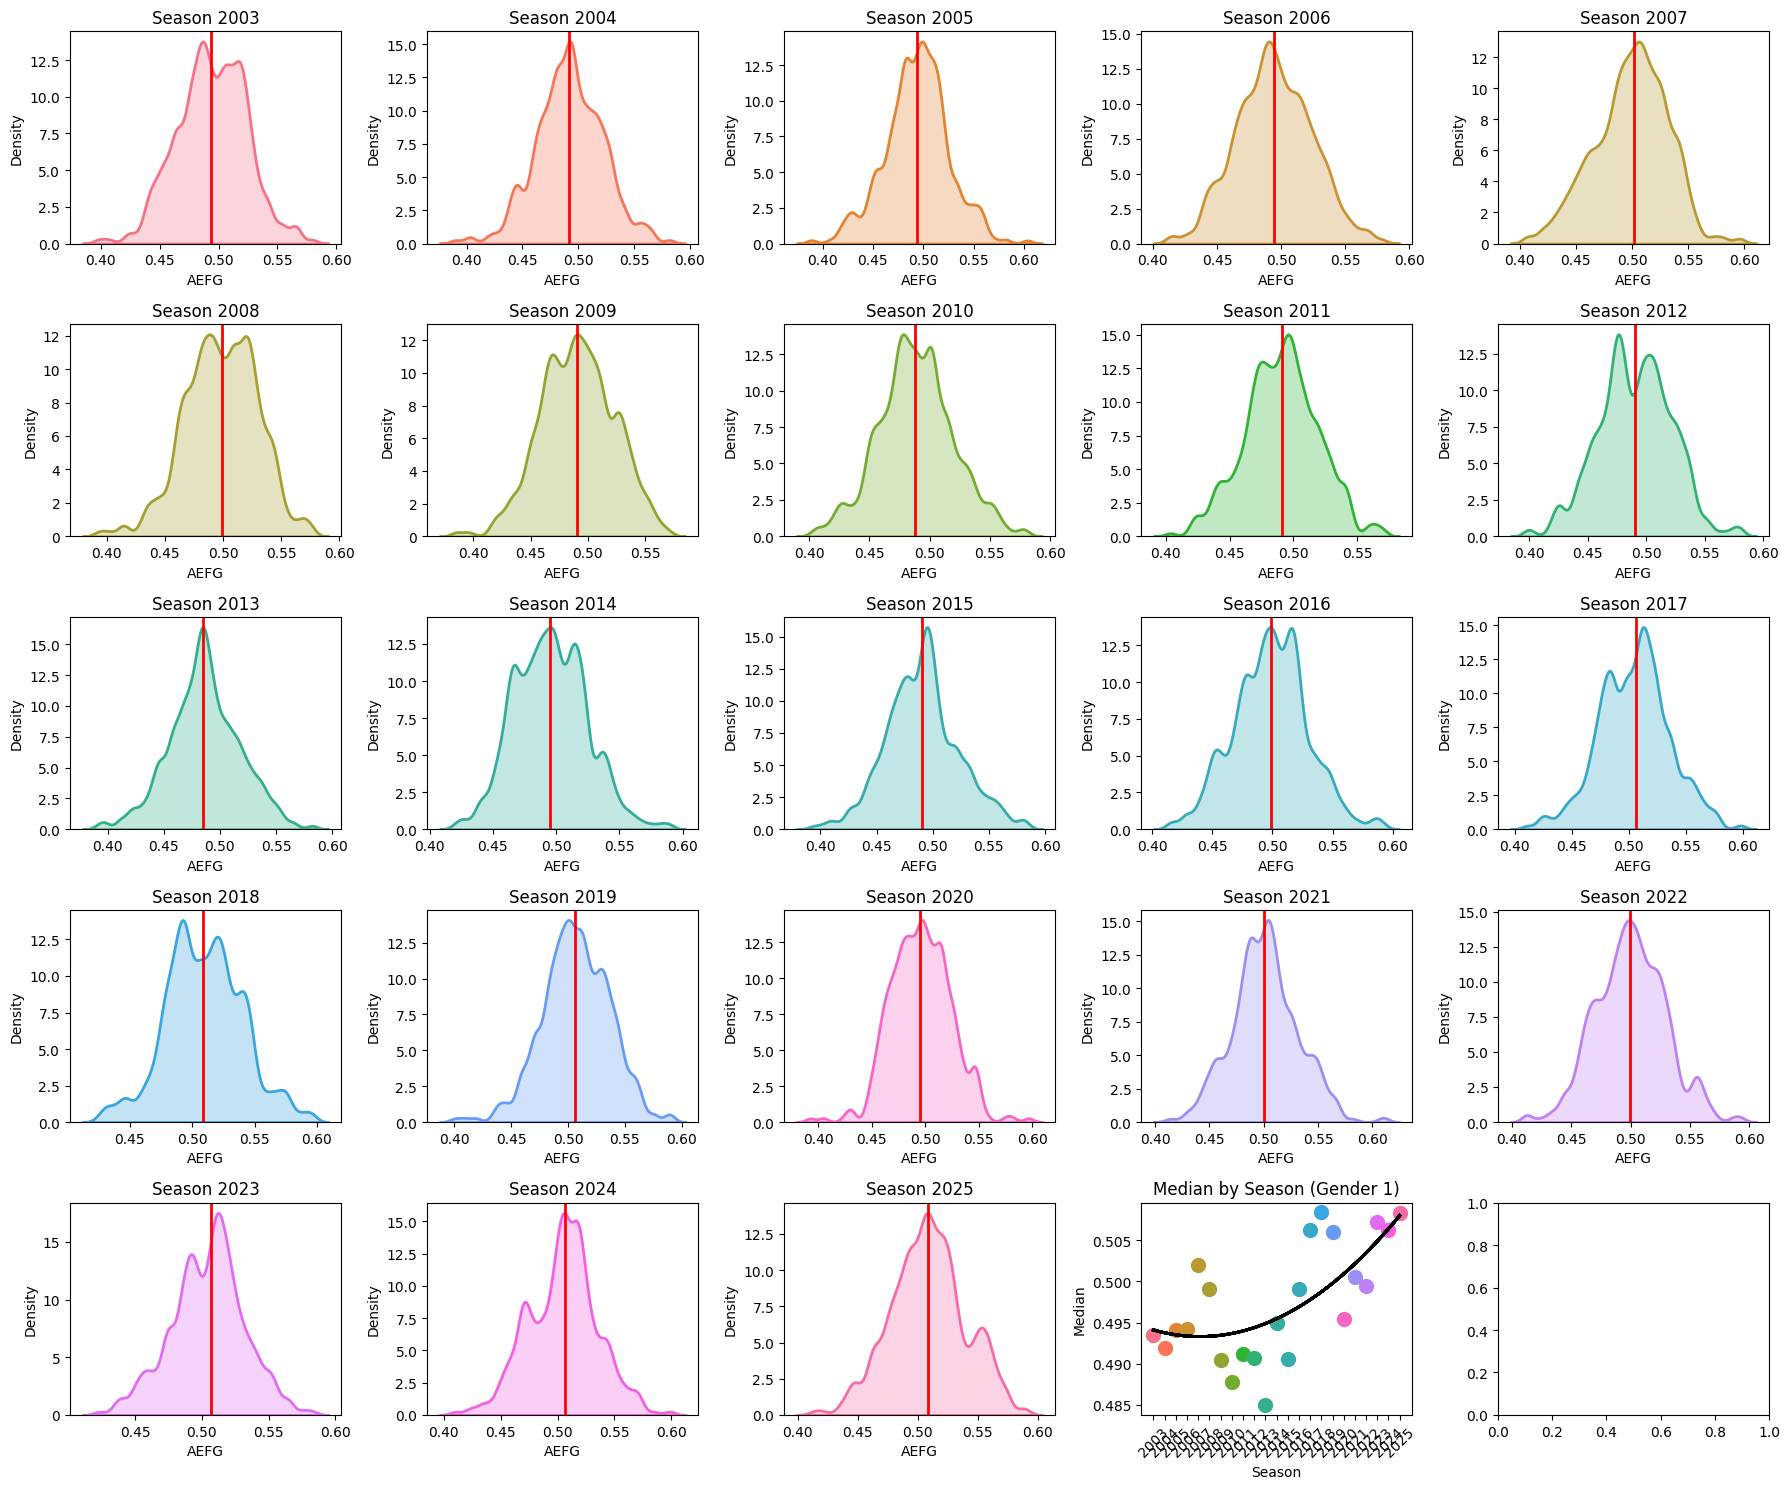

In [24]:
# Some plotting to visualize a feature from the data and how that feature has changed over the seasons... can specify the feature and the gender

column_name = "AEFG"
n_seasons = len(df[df["Gender"] == 1]["Season"].unique())
n_rows = (n_seasons + 4) // 5
palette = sns.color_palette("husl", n_seasons)
season_color = {
    val: palette[i] for i, val in enumerate(df[df["Gender"] == 1]["Season"].unique())
}

fig, axes = plt.subplots(nrows=n_rows, ncols=5, figsize=(18, 3 * n_rows))

for i, (season, data) in enumerate(df[df["Gender"] == 1].groupby("Season")):
    row = i // 5
    col = i % 5
    sns.kdeplot(
        data=data,
        x=column_name,
        fill=True,
        alpha=0.3,
        linewidth=2,
        color=season_color[season],
        ax=axes[row, col],
    )
    axes[row, col].axvline(data[column_name].median(), color="red", linewidth=2)
    axes[row, col].set_title(f"Season {season}")

    # add scatter plot of median
    ax_median = plt.subplot(n_rows, 5, n_seasons + 1)
    ax_median.scatter(
        season, data[column_name].median(), color=season_color[season], s=100
    )
    ax_median.set_xlabel("Season")
    ax_median.set_ylabel("Median")
    ax_median.set_xticks(df[df["Gender"] == 1]["Season"].unique())
    ax_median.set_xticklabels(df[df["Gender"] == 1]["Season"].unique(), rotation=45)
    ax_median.set_title("Median by Season (Gender 1)")

    # add trendline to median scatter plot
    x = np.array(df[df["Gender"] == 1]["Season"].unique())
    y = np.array(
        [
            data[column_name].median()
            for season, data in df[df["Gender"] == 1].groupby("Season")
        ]
    )
    p = np.polyfit(x, y, deg=2)
    f = np.poly1d(p)
    x_new = np.linspace(x[0], x[-1], 100)
    ax_median.plot(x_new, f(x_new), color="black", linewidth=2)

fig.tight_layout()
plt.show()

In [25]:
# Cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [26]:
scores = {"XGB": {}}
importances = {}

In [27]:
# XGBoost performed best and was then used for training

xgb_clf = xgboost.XGBClassifier()
brier = cross_val_score(
    xgb_clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring="neg_brier_score"
)
brier = np.mean(brier) * -1
xgb_clf.fit(X_train, y_train)
pred_Y = xgb_clf.predict_proba(X_test)
scores["XGB"]["Brier"] = brier
importances["XGB"] = xgb_clf.feature_importances_

In [28]:
# Create dataframes for both the score dictionary and importance dictionary

score_df = pd.DataFrame.from_dict(scores).T
importances_df = pd.DataFrame.from_dict(importances)
importances_df.index = X_train.columns
importances_df["mean_importance"] = importances_df.mean(axis=1)
importances_df = importances_df.sort_values(by="XGB", ascending=False)

In [29]:
score_df

,Brier
XGB,0.16579


In [30]:
importances_df

,XGB,mean_importance
AWRatio,0.330392,0.330392
BWRatio,0.322580,0.322580
SeedB,0.051679,0.051679
SeedA,0.041326,0.041326
BPPP,0.017434,0.017434
APPP,0.015810,0.015810
TeamA,0.010214,0.010214
TeamB,0.009575,0.009575
BOppTS,0.009539,0.009539
ATOVPct,0.008899,0.008899


In [31]:
def create_input_data(year, scaler, men_women_seeds):
    # Load in sample submission and format
    sample = pd.read_csv(
        "/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv"
    )
    sample["ID"] = sample["ID"].str.replace("2025_", str(year) + "_", regex=False)
    sample["Season"] = sample["ID"].apply(lambda x: int(x.split("_")[0]))
    sample["TeamA"] = sample["ID"].apply(lambda x: int(x.split("_")[1]))
    sample["TeamB"] = sample["ID"].apply(lambda x: int(x.split("_")[2]))

    sample["Season"] = sample.Season.astype("int")
    sample["TeamA"] = sample.TeamA.astype("int")
    sample["TeamB"] = sample.TeamB.astype("int")

    # Merge sample with seed data
    sample = (
        sample.merge(
            men_women_seeds[["Season", "Seed", "TeamID"]],
            how="left",
            left_on=["Season", "TeamA"],
            right_on=["Season", "TeamID"],
        )
        .drop("TeamID", axis=1)
        .rename(columns={"Seed": "SeedA"})
        .fillna(0)
    )
    sample = (
        sample.merge(
            men_women_seeds[["Season", "Seed", "TeamID"]],
            how="left",
            left_on=["Season", "TeamB"],
            right_on=["Season", "TeamID"],
        )
        .drop("TeamID", axis=1)
        .rename(columns={"Seed": "SeedB"})
        .fillna(0)
    )

    # Merge submission_df with the engineered features
    # The data for 2025 is only the regular season... denote this with "0"
    sample = pd.merge(
        sample,
        df[
            [
                "Season",
                "TeamA",
                "Gender",
                "AWRatio",
                "AEFG",
                "AOppEFG",
                "APPP",
                "AOppPPP",
                "ATS",
                "AOppTS",
                "AORTG",
                "ADRTG",
                "ATOVPct",
                "AOppTOV",
                "AORPct",
                "ADRPct",
                "AFTR",
                "AOppFTR",
            ]
        ]
        .groupby(["Season", "TeamA"])
        .mean(),
        on=["Season", "TeamA"],
        how="left",
    )
    sample = pd.merge(
        sample,
        df[
            [
                "Season",
                "TeamB",
                "BWRatio",
                "BEFG",
                "BOppEFG",
                "BPPP",
                "BOppPPP",
                "BTS",
                "BOppTS",
                "BORTG",
                "BDRTG",
                "BTOVPct",
                "BOppTOV",
                "BORPct",
                "BDRPct",
                "BFTR",
                "BOppFTR",
            ]
        ]
        .groupby(["Season", "TeamB"])
        .mean(),
        on=["Season", "TeamB"],
        how="left",
    )

    sample["Set"] = 0
    sample[
        [
            "Gender",
            "AWRatio",
            "AEFG",
            "AOppEFG",
            "APPP",
            "AOppPPP",
            "ATS",
            "AOppTS",
            "AORTG",
            "ADRTG",
            "ATOVPct",
            "AOppTOV",
            "AORPct",
            "ADRPct",
            "AFTR",
            "AOppFTR",
            "TeamB",
            "BWRatio",
            "BEFG",
            "BOppEFG",
            "BPPP",
            "BOppPPP",
            "BTS",
            "BOppTS",
            "BORTG",
            "BDRTG",
            "BTOVPct",
            "BOppTOV",
            "BORPct",
            "BDRPct",
            "BFTR",
            "BOppFTR",
        ]
    ] = sample[
        [
            "Gender",
            "AWRatio",
            "AEFG",
            "AOppEFG",
            "APPP",
            "AOppPPP",
            "ATS",
            "AOppTS",
            "AORTG",
            "ADRTG",
            "ATOVPct",
            "AOppTOV",
            "AORPct",
            "ADRPct",
            "AFTR",
            "AOppFTR",
            "TeamB",
            "BWRatio",
            "BEFG",
            "BOppEFG",
            "BPPP",
            "BOppPPP",
            "BTS",
            "BOppTS",
            "BORTG",
            "BDRTG",
            "BTOVPct",
            "BOppTOV",
            "BORPct",
            "BDRPct",
            "BFTR",
            "BOppFTR",
        ]
    ].fillna(
        sample[
            [
                "Gender",
                "AWRatio",
                "AEFG",
                "AOppEFG",
                "APPP",
                "AOppPPP",
                "ATS",
                "AOppTS",
                "AORTG",
                "ADRTG",
                "ATOVPct",
                "AOppTOV",
                "AORPct",
                "ADRPct",
                "AFTR",
                "AOppFTR",
                "TeamB",
                "BWRatio",
                "BEFG",
                "BOppEFG",
                "BPPP",
                "BOppPPP",
                "BTS",
                "BOppTS",
                "BORTG",
                "BDRTG",
                "BTOVPct",
                "BOppTOV",
                "BORPct",
                "BDRPct",
                "BFTR",
                "BOppFTR",
            ]
        ].mean()
    )

    # Engineer the last feature and select the features for predictions
    sample[["Season", "TeamB", "TeamA", "SeedA", "SeedB", "Gender", "Set"]] = sample[
        ["Season", "TeamB", "TeamA", "SeedA", "SeedB", "Gender", "Set"]
    ].astype(int)
    sample["4fODiff"] = (
        (0.4 * (sample["AEFG"] - sample["BEFG"]))
        - (0.25 * (sample["ATOVPct"] - sample["BTOVPct"]))
        + (0.2 * (sample["AORPct"] - sample["BORPct"]))
        + (0.15 * (sample["AFTR"] - sample["BFTR"]))
    )
    sample["4fDDiff"] = (
        -(0.4 * (sample["AOppEFG"] - sample["BOppEFG"]))
        + (0.25 * (sample["AOppTOV"] - sample["BOppTOV"]))
        + (0.2 * (sample["ADRPct"] - sample["BDRPct"]))
        - (0.15 * (sample["AOppFTR"] - sample["BOppFTR"]))
    )
    sample["4F"] = sample["4fODiff"] - sample["4fDDiff"]
    sample.drop(["4fODiff", "4fDDiff"], axis=1, inplace=True)
    sample = sample[
        [
            "Season",
            "Set",
            "Gender",
            "TeamA",
            "TeamB",
            "AWRatio",
            "BWRatio",
            "AEFG",
            "BEFG",
            "AOppEFG",
            "BOppEFG",
            "APPP",
            "BPPP",
            "AOppPPP",
            "BOppPPP",
            "ATS",
            "BTS",
            "AOppTS",
            "BOppTS",
            "AORTG",
            "BORTG",
            "ADRTG",
            "BDRTG",
            "ATOVPct",
            "BTOVPct",
            "AOppTOV",
            "BOppTOV",
            "AORPct",
            "BORPct",
            "ADRPct",
            "BDRPct",
            "AFTR",
            "BFTR",
            "AOppFTR",
            "BOppFTR",
            "4F",
            "SeedA",
            "SeedB",
        ]
    ]
    # Scale data
    sample = pd.DataFrame(
        scaler.transform(sample), columns=sample.columns, index=sample.index
    )

    return sample

In [32]:
sample = create_input_data(2025, scaler, men_women_seeds)

In [33]:
sample.head()

,Season,Set,Gender,TeamA,TeamB,AWRatio,BWRatio,AEFG,BEFG,AOppEFG,...,BORPct,ADRPct,BDRPct,AFTR,BFTR,AOppFTR,BOppFTR,4F,SeedA,SeedB
0,1.0,0.0,1.0,0.0,0.000420,0.409091,0.115385,0.565385,0.660434,0.727459,...,0.275023,0.593638,0.654475,0.586759,0.532923,0.759454,0.427297,0.540719,0.0,0.0
1,1.0,0.0,1.0,0.0,0.000841,0.409091,0.791667,0.565385,0.807351,0.727459,...,0.512594,0.593638,0.711856,0.586759,0.285236,0.759454,0.411202,0.569893,0.0,0.0
2,1.0,0.0,1.0,0.0,0.001261,0.409091,0.840000,0.565385,0.835125,0.727459,...,0.623531,0.593638,0.680104,0.586759,0.640547,0.759454,0.365469,0.404917,0.0,0.0
3,1.0,0.0,1.0,0.0,0.001681,0.409091,0.260870,0.565385,0.502374,0.727459,...,0.582452,0.593638,0.470816,0.586759,0.585524,0.759454,0.680197,0.419058,0.0,0.0
4,1.0,0.0,1.0,0.0,0.002102,0.409091,0.440000,0.565385,0.567501,0.727459,...,0.382459,0.593638,0.584514,0.586759,0.393603,0.759454,0.501059,0.549558,0.0,0.0


In [34]:
# Predict on submission set and prepare submission for the competition

submission_df = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv"
)
sub_pred = xgb_clf.predict_proba(sample).astype(float)
sub_pred = sub_pred[:, 1]
submission_df["Pred"] = sub_pred

In [35]:
submission_df.head()

,ID,Pred
0,2025_1101_1102,0.667722
1,2025_1101_1103,0.019967
2,2025_1101_1104,0.012519
3,2025_1101_1105,0.663164
4,2025_1101_1106,0.413561


# Create label data and evaluate accuracy

In [36]:
# Use tourney results for evaluation
m_tourney = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv"
)
w_tourney = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyCompactResults.csv"
)
tourney_results = pd.concat([m_tourney, w_tourney])
print(tourney_results)

      Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0       1985     136     1116      63     1234      54    N      0
1       1985     136     1120      59     1345      58    N      0
2       1985     136     1207      68     1250      43    N      0
3       1985     136     1229      58     1425      55    N      0
4       1985     136     1242      49     1325      38    N      0
...      ...     ...      ...     ...      ...     ...  ...    ...
1645    2024     147     3163      80     3425      73    A      0
1646    2024     147     3234      94     3261      87    H      0
1647    2024     151     3234      71     3163      69    N      0
1648    2024     151     3376      78     3301      59    N      0
1649    2024     153     3376      87     3234      75    N      0

[4168 rows x 8 columns]


In [37]:
def create_all_tourney_combination(tourney_results):
    # Ensure small ID comes first
    df = tourney_results.copy()
    df["SmallID"] = df[["WTeamID", "LTeamID"]].min(axis=1)
    df["BigID"] = df[["WTeamID", "LTeamID"]].max(axis=1)

    # Create ID in the format year_smallerId_biggerId
    df["ID"] = (
        df["Season"].astype(str)
        + "_"
        + df["SmallID"].astype(str)
        + "_"
        + df["BigID"].astype(str)
    )

    # Set prediction based on the original winner
    df["Pred"] = (df["SmallID"] == df["WTeamID"]).astype(int)

    return df[["ID", "Pred"]]

In [38]:
tourney_df = create_all_tourney_combination(tourney_results)
print(tourney_df)

                  ID  Pred
0     1985_1116_1234     1
1     1985_1120_1345     1
2     1985_1207_1250     1
3     1985_1229_1425     1
4     1985_1242_1325     1
...              ...   ...
1645  2024_3163_3425     1
1646  2024_3234_3261     1
1647  2024_3163_3234     0
1648  2024_3301_3376     0
1649  2024_3234_3376     0

[4168 rows x 2 columns]


In [39]:
from sklearn.metrics import brier_score_loss


def create_evaluation_data(tourney_df, prediction):
    # Merge to keep only matching IDs
    merged_df = tourney_df.merge(prediction, on="ID", suffixes=("_true", "_pred"))
    if merged_df.empty:
        # If there are no matchings between label data and prediction, return 0
        return None

    return merged_df

In [40]:
# Evaluate average brier score
brier_score_sum = 0
count = 0
# Read Data
men_tournament = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyDetailedResults.csv"
)
men_seeds = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv"
)
men_regular = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv"
)
women_tournament = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv"
)
women_seeds = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySeeds.csv"
)
women_regular = pd.read_csv(
    "/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonDetailedResults.csv"
)

for year in range(2019, 2025):
    # Extract data accoding to year
    men_tournament_extracted = men_tournament[men_tournament["Season"] < year]
    men_seeds_extracted = men_seeds[men_seeds["Season"] <= year]
    men_regular_extracted = men_regular[men_regular["Season"] <= year]
    women_tournament_extracted = women_tournament[women_tournament["Season"] < year]
    women_seeds_extracted = women_seeds[women_seeds["Season"] <= year]
    women_regular_extracted = women_regular[women_regular["Season"] <= year]

    (
        X_train,
        X_test,
        y_train,
        y_test,
        scaler,
        df,
        men_women_seeds,
    ) = create_train_and_test_data(
        men_tournament_extracted,
        men_seeds_extracted,
        men_regular_extracted,
        women_tournament_extracted,
        women_seeds_extracted,
        women_regular_extracted,
    )
    xgb_clf = xgboost.XGBClassifier()
    xgb_clf.fit(X_train, y_train)

    pred_df = pd.read_csv(
        "/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv"
    )
    pred_df["ID"] = pred_df["ID"].str.replace("2025_", str(year) + "_", regex=False)

    # Predict result
    test_data = create_input_data(year, scaler, men_women_seeds)
    prediction_test_data = xgb_clf.predict_proba(test_data).astype(float)
    prediction_test_data = prediction_test_data[:, 1]
    pred_df["Pred"] = prediction_test_data

    # Extract matching values
    merged_df = create_evaluation_data(tourney_df, pred_df)

    # Calculate brier score
    if not merged_df is None:
        y_true = merged_df["Pred_true"]  # Actual results (0 or 1)
        y_pred = merged_df["Pred_pred"]  # Predicted probabilities
        year_brier_score = brier_score_loss(y_true, y_pred)
        brier_score_sum += year_brier_score
        print("{0}: {1}".format(year, year_brier_score))
        count += 1

print("count: ", count)
brier_score = brier_score_sum / count
print("Average brier score:", brier_score)

<ipython-input-22-386acb8a36bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament[

2019: 0.16790235584038682


<ipython-input-22-386acb8a36bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament[

2021: 0.2000892699230591


<ipython-input-22-386acb8a36bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament[

2022: 0.1885319467753008


<ipython-input-22-386acb8a36bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament[

2023: 0.18229063489045697


<ipython-input-22-386acb8a36bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_tournament.drop(["NumOT", "WLoc"], axis=1, inplace=True)
<ipython-input-22-386acb8a36bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_tournament[

2024: 0.16408159222127128
count:  5
Average brier score: 0.180579159930095


# Make submission

In [41]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)